Project image sequence colorization 

LACHOUQUE Jacque 
KOÏTA Adama


In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import sys
import os

In [5]:
%matplotlib inline

import numpy as np # grey images are stored in memory as 2D arrays, color images as 3D arrays
import cv2 as cv2 # opencv computer vision library
from skimage import io # for io.imread
from matplotlib import pyplot as plt # ploting
from matplotlib import colors # ploting

# interactive notebook widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


In [19]:
def imshow_plt(images, titles, nrows = 0, ncols=0, figsize = (15,20)):
    """Plot a multiple images with titles.

    Parameters
    ----------
    images : image list
    titles : title list
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    if ncols == 0 and nrows == 0:
      ncols = len(images)
      nrows = 1
    if ncols == 0:
      ncols = len(images) // nrows
    if nrows == 0:
      nrows = len(images) // ncols
      
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, squeeze=False, figsize = figsize)
    for i, image in enumerate(images):
        axeslist.ravel()[i].imshow(image, cmap=plt.gray(), vmin=0, vmax=255)
        axeslist.ravel()[i].set_title(titles[i])
        axeslist.ravel()[i].set_axis_off()
    plt.tight_layout() # optional

    
def imshow_cv(image, cmap=None):
  plt.imshow(image, cmap)
  plt.show()

(557, 362, 3)


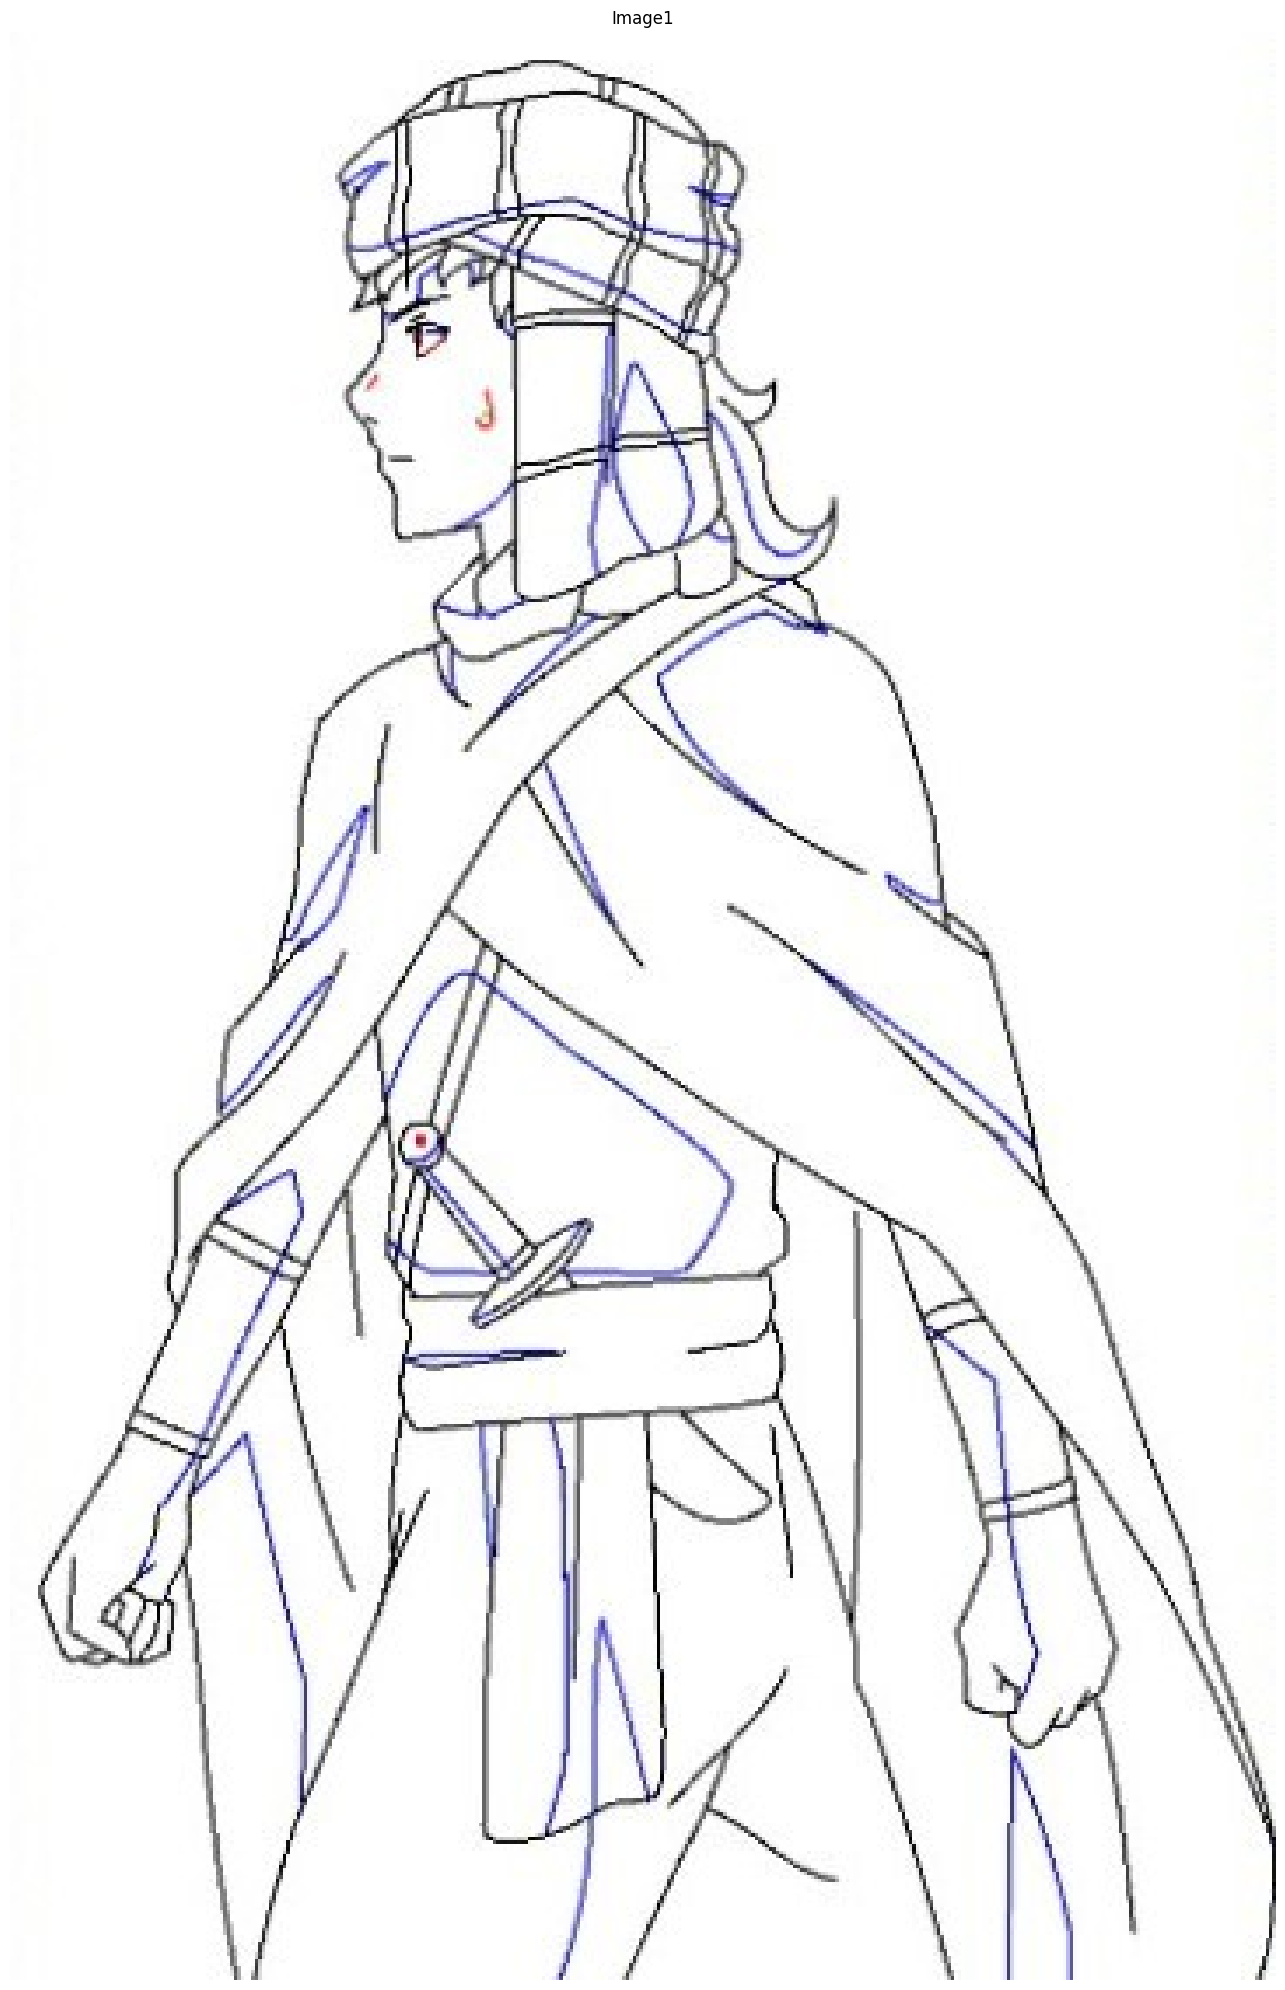

In [64]:
# Read an image as a PyTorch tensor
myimage = io.imread("dataset/sketch/1.jpg")
imshow_plt( [myimage], ['Image1'])
print(myimage.shape)

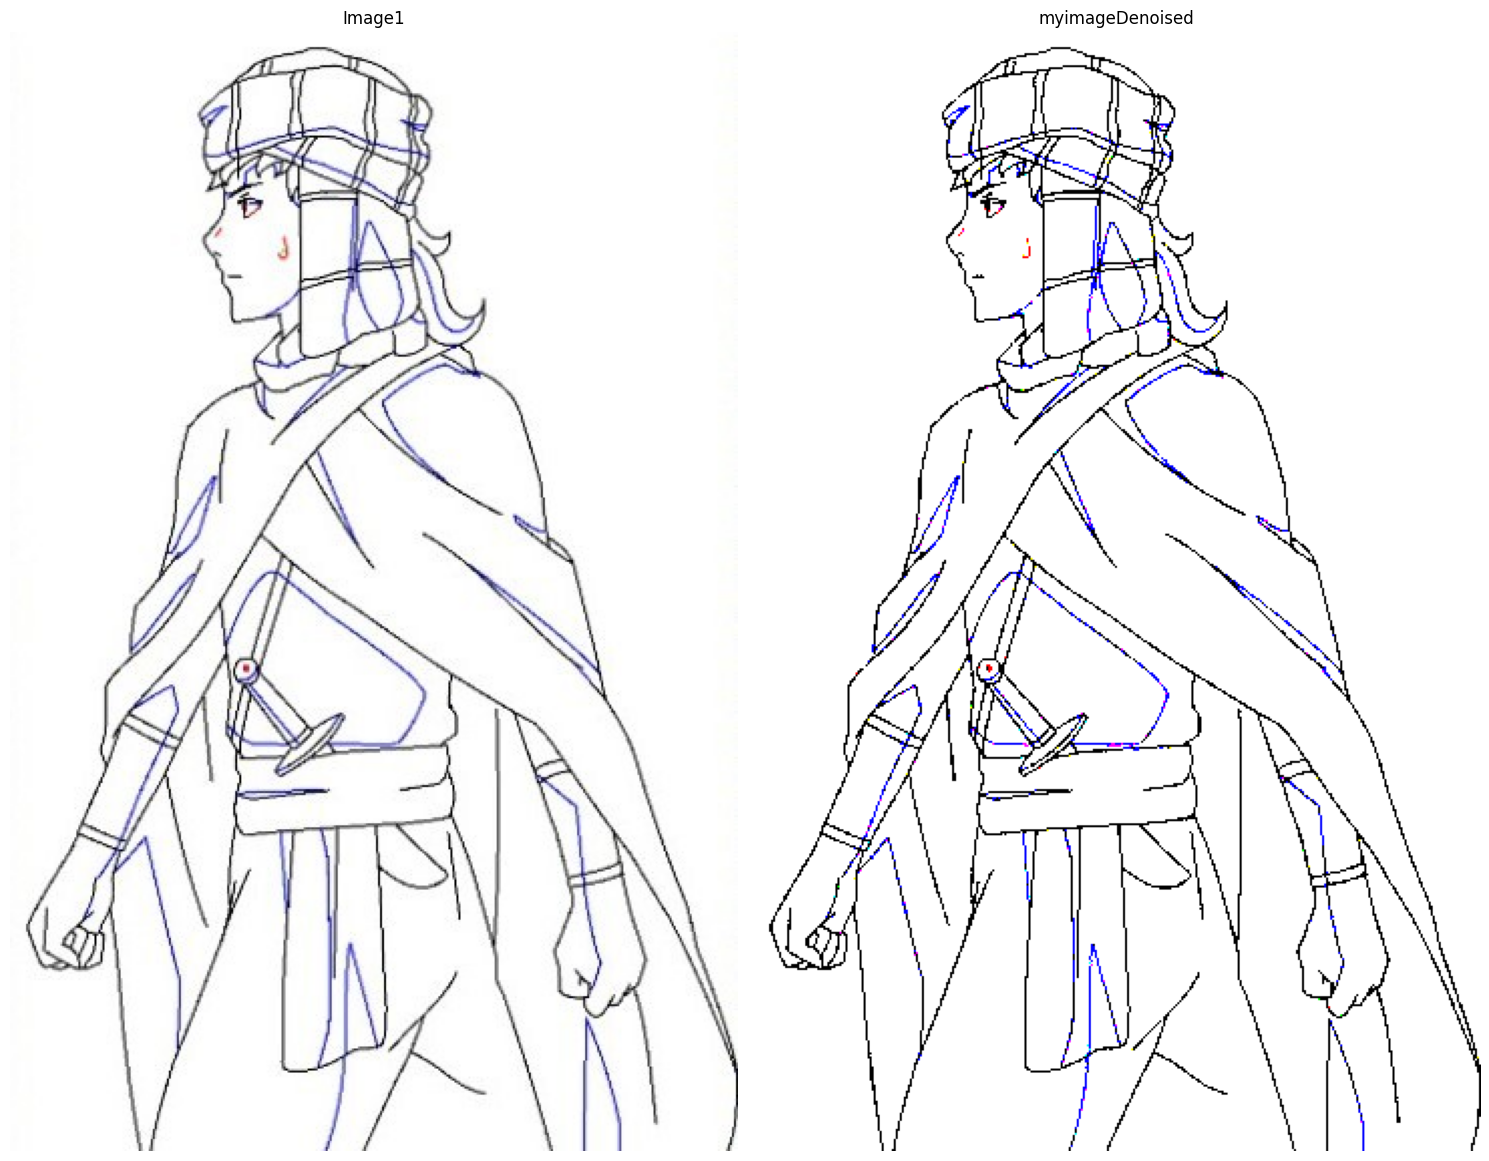

In [281]:


def threshold(img, value):
   return np.where(img >= value, 255, 0)
myimage_denoised = threshold(myimage,140)

imshow_plt( [myimage, myimage_denoised], ['Image1', 'myimageDenoised'])


(557, 362)


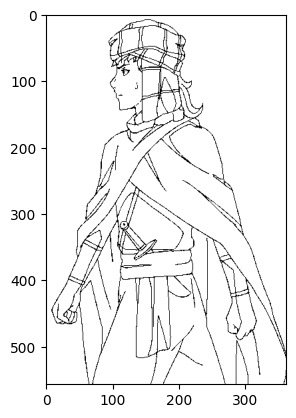

In [279]:
"""classes_matrix = np.zeros((myimage_denoised.shape[0], myimage_denoised.shape[1],1))
treatedPixMat =  np.where(myimage_denoised==(255,255,255),treatedPixMat,255)
lines_color_values = [(0,0,0),
(255,0,0),
(0,255,0),
(0,0,255),
(255,255,0),
(0,255,255),
(255,0,255)]
lines_color_values_array = np.array(lines_color_values)

#classes_matrix =  np.where((myimage_denoised==(0,0,0)) | (myimage_denoised==(255,0,0)) | (myimage_denoised==(0,255,0)) | (myimage_denoised==(0,0,255)) | (myimage_denoised==(255,255,0))| (myimage_denoised==(0,255,255)) | (myimage_denoised==(255,0,255)),classes_matrix,0)
treatedPixMat =  np.where(np.isin(myimage_denoised, lines_color_values).all(axis=-1, keepdims=True),treatedPixMat,(255,255,255))
print(treatedPixMat.shape)
imshow_cv(treatedPixMat )"""


treatedPixMat = np.zeros((myimage_denoised.shape[0], myimage_denoised.shape[1]))
treatedPixMat =  np.where(
    (myimage_denoised[..., 0] == 255) & 
    (myimage_denoised[..., 1] == 255) & 
    (myimage_denoised[..., 2] == 255),
    
    treatedPixMat, -1
)

print(treatedPixMat.shape)
imshow_cv(treatedPixMat)

In [170]:
list_index_zeros = list(zip(*np.where(treatedPixMat == 0))) # * separe les deux array produit par np.where en deux array distinc et zip combine les élement pour les transformé en tuple
print(np.array(list_index_zeros).shape)
print(list_index_zeros[2])


(190168, 2)
(np.int64(0), np.int64(2))


In [190]:
print(treatedPixMat[0,50])

0.0


In [ ]:
from random import randint

def apply_class_in_matrix(classes_matrix,treated_pixels, class_num):
    """print( "i:" ,i )
    print(" j:", j)
    print("pixel value",classes_matrix[i][j])"""
      
      #parcourir la liste horizontalemnt jusqua tombé sur un pixel de contour puis aller a la prochaine ligne 
      #si le pixel davant le bord est traité et que le pixel dapres le bords nai pas traité on jump directement dans le pixel dapres le bord qui nest pas traité 
      #une fois arrivé au dernier pixel return la matrice 
    # dans la loupe tant qu'il y aura un des pixel non traité il fera un nouvelle 

    

    new_treated_pixels = treated_pixels.copy()
    for line in range(classes_matrix.shape[0]):
        for pix in range(classes_matrix.shape[1]):#parcourir de la gauche 
           
            if(classes_matrix[line][pix] == -1):
                    if(pix !=0):
                        if(treated_pixels[line][pix-1]):#and classes_matrix[line][pix+1] ==0
                            continue
                        else:
                            break

                    
            if(classes_matrix[line][pix] == 0):
                classes_matrix[line][pix] = class_num
                new_treated_pixels[line][pix] = True



        for pix in range(classes_matrix.shape[1]-1,0,-1): #parcourir de la droite 
            if(classes_matrix[line][pix] == -1 ):
                if(classes_matrix[line][pix] == -1):
                    if(pix !=classes_matrix.shape[1]-1):
                        if(treated_pixels[line][pix+1]):#and classes_matrix[line][pix+1] ==0
                            continue
                        else:
                            break
            if(classes_matrix[line][pix] == 0):
                classes_matrix[line][pix] = class_num
                new_treated_pixels[line][pix] = True
                
    return  classes_matrix, new_treated_pixels


def classes_matrix_to_image(classes_matrix, list_class):
    image = np.zeros((classes_matrix.shape[0],classes_matrix.shape[1],3), dtype=int)
    for c in list_class:
        mask = (classes_matrix == c)
        random_color = (randint(100, 255), randint(100, 255), randint(100, 255))
        image[mask] = random_color
        #print("class "+ str(c)+" color:",random_color)
    return image

def assign_class_to_pixel(image):

    #create matrix of classes
    classes_matrix = np.zeros((myimage_denoised.shape[0], myimage_denoised.shape[1]))
    classes_matrix =  np.where(
    (myimage_denoised[..., 0] == 255) & 
    (myimage_denoised[..., 1] == 255) & 
    (myimage_denoised[..., 2] == 255),
    classes_matrix, -1)

    print(classes_matrix.shape)
    imshow_cv(classes_matrix)
    
    last_class = 1
    classes_num_list = []
    show_steps = np.array([0,1,250])

    treated_pixels = np.full_like(classes_matrix, False, dtype=bool)
    mask = (classes_matrix == -1)
    treated_pixels[mask] = True        
    #print(treated_pixels)

    while(np.isin(classes_matrix,0).any()):
        classes_matrix, new_treated_pixels = apply_class_in_matrix(classes_matrix, treated_pixels,last_class)
        treated_pixels = new_treated_pixels.copy()
        #print("shape classes_matrix",classes_matrix.shape)
        #print("step",last_class-1)
        imshow_cv(classes_matrix_to_image(classes_matrix, classes_num_list))
        #print(classes_matrix[200])
        #imshow_plt([classes_matrix_to_image(classes_matrix, classes_num_list)],['classe'+str(last_class)])


        last_class+=1
        classes_num_list.append(last_class)


    return classes_matrix, classes_num_list




(557, 362)


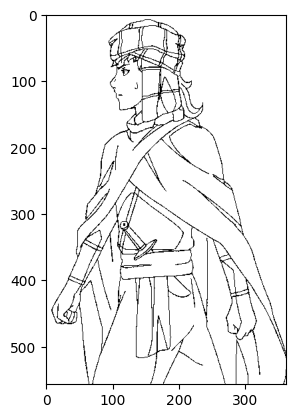

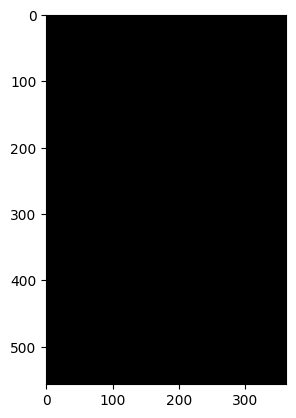

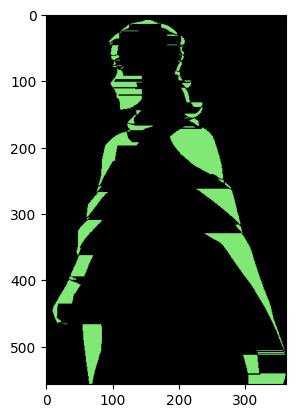

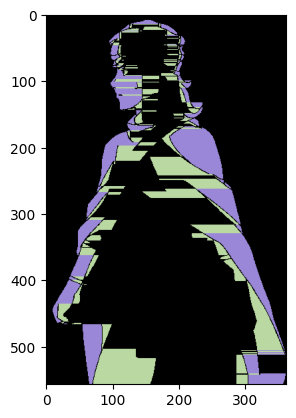

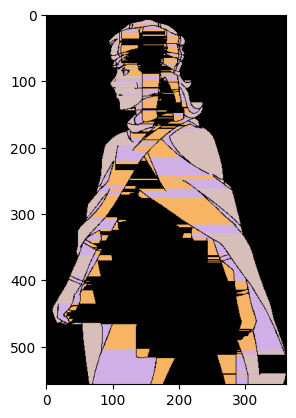

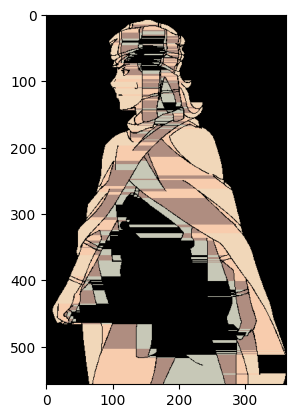

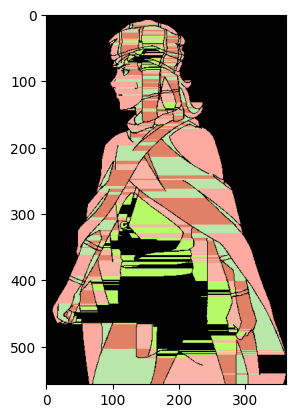

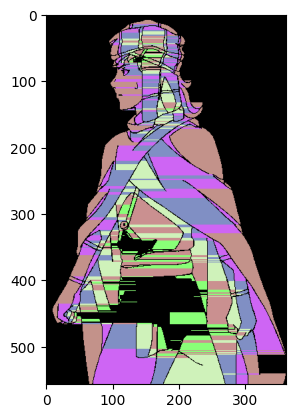

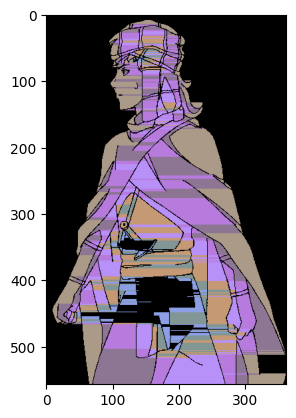

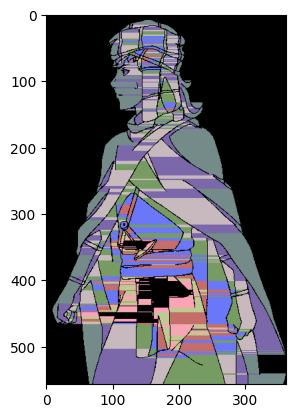

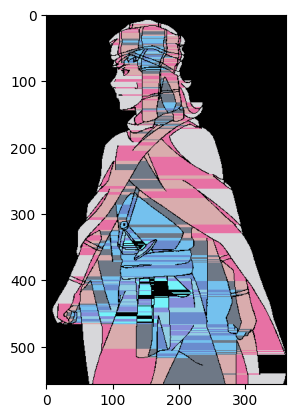

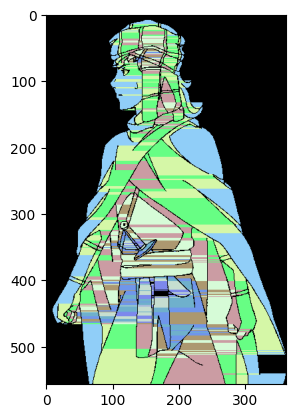

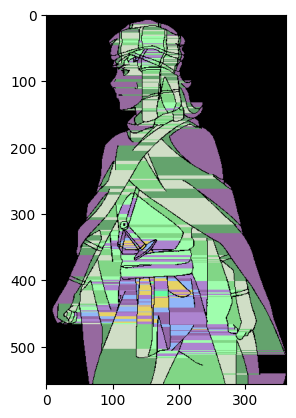

ValueError: too many values to unpack (expected 2)

In [ ]:
classes_matrix, classes_num_list = assign_class_to_pixel(myimage_denoised)
imshow_plt([classes_matrix_to_image(classes_matrix, classes_num_list)], ["naive 1 colorization"])

In [ ]:
#faire methode de remplissage classque et recursif. Les colcible seront nimporte quel pixel non traité